### Goals

Debug the current svm pipeline by 
1) Loading the data in the same way and plotting it
2) fiddling with hyperparams

In [ ]:
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import ccf_streamlines.projection as ccfproj
from datasets import load_from_disk
import yaml

import sys
# import ../utils
sys.path.append('../')

from utils import reflect_points_to_left
from svc_plotting import *


In [2]:
root_path = os.environ["ROOT_DATA_PATH"]
ccf_files_path = os.path.join(root_path, "CCF_files")

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=    os.path.join(ccf_files_path,"flatmap_butterfly.nrrd"),
    labels_file=    os.path.join(ccf_files_path,"labelDescription_ITKSNAPColor.txt"),
)

bf_left_boundaries_flat = bf_boundary_finder.region_boundaries()
bf_right_boundaries_flat = bf_boundary_finder.region_boundaries(
    hemisphere='right_for_both',
    view_space_for_other_hemisphere='flatmap_butterfly',
)

In [4]:
#get system variable
data_dir = os.environ.get('ROOT_DATA_PATH')

## Even numbered brains are controls; odd numbered brains are enucleated
animals = ["filt_neurons_D076_1L_CCFv2_newtypes.h5ad",
    "filt_neurons_D077_1L_CCFv2_newtypes.h5ad",
    # "filt_neurons_D077_2L_CCFv2_newtypes.h5ad",
    "filt_neurons_D078_1L_CCFv2_newtypes.h5ad",
    # "filt_neurons_D078_2L_CCFv2_newtypes.h5ad",
    "filt_neurons_D079_3L_CCFv2_newtypes.h5ad",
    # "filt_neurons_D079_4L_CCFv2_newtypes.h5ad"
    ]
data_dir = os.environ.get('ROOT_DATA_PATH')
ccf_files_path = os.path.join(data_dir, "CCF_files")



space = "flatmap_butterfly"
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=    os.path.join(ccf_files_path,f"{space}.nrrd"),
    labels_file=    os.path.join(ccf_files_path,"labelDescription_ITKSNAPColor.txt"),
)
bf_left_boundaries_flat = bf_boundary_finder.region_boundaries()


# move up the hierarchy to get rid of the smallest 'areas' which are actually layers
with open('../../data/files/area_ancestor_id_map.json', 'r') as f:
    area_ancestor_id_map = json.load(f)
with open('../../data/files/area_name_map.json', 'r') as f:
    area_name_map = json.load(f)
area_name_map['0'] = 'outside_brain'
annotation2area_int = {0.0:0} # Map from annotation id to area id. Float to int
for a in area_ancestor_id_map.keys(): 
    higher_area_id = area_ancestor_id_map[str(int(a))][1] if len(area_ancestor_id_map[str(int(a))])>1 else a    
    annotation2area_int[float(a)] = higher_area_id

unique_areas = np.unique(list(annotation2area_int.values())) # List of unique areas (noncontiguous ints)
unique_annos = [area_name_map[str(int(a))] for a in unique_areas] # List of unique area names
area_classes = np.arange(len(unique_areas)) # Create a class for each area (0, 1, 2, ...)
id2id = {float(k):v for (k,v) in zip(unique_areas, area_classes)} # Map from area id to class id
annoation2area_class = {k: id2id[int(v)] for k,v in annotation2area_int.items()} # Map from annotation to area class
id2id_rev = {v:k for k,v in id2id.items()} # Map from class id to area id
area_class2area_name = {k: area_name_map[str(int(v))] for k,v in id2id_rev.items()} # Map from area class to area name



#load data
adata_list = []
for animal in animals:
    adata = ad.read_h5ad(os.path.join("../../data/anndatas", animal))
    animal_name = '_'.join(animal.split('_')[2:4])
    adata.obs['CCFano'] = adata.obs['CCFano'].astype('category')
    adata.obs['CFFname'] = adata.obs['CCFname'].astype('category')
    adata.obs['area_label'] = adata.obs['CCFano'].map(annoation2area_class).astype('category')
    adata.obs['area_name'] = adata.obs['area_label'].map(area_class2area_name).astype('category')

    # remove cells in the 'outside_brain' area
    adata = adata[adata.obs['area_name'] != 'outside_brain']

    subcortical_mask = np.isnan(adata.obsm['CCF_streamlines']).any(axis=1)
    adata = adata[~subcortical_mask]

    adata_list.append(adata)

In [ ]:
color_map, label_names = create_master_colormap(adata_list, area_class2area_name)


/tmp/ipykernel_858719/2656680314.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])


Accuracy 75.1086538746


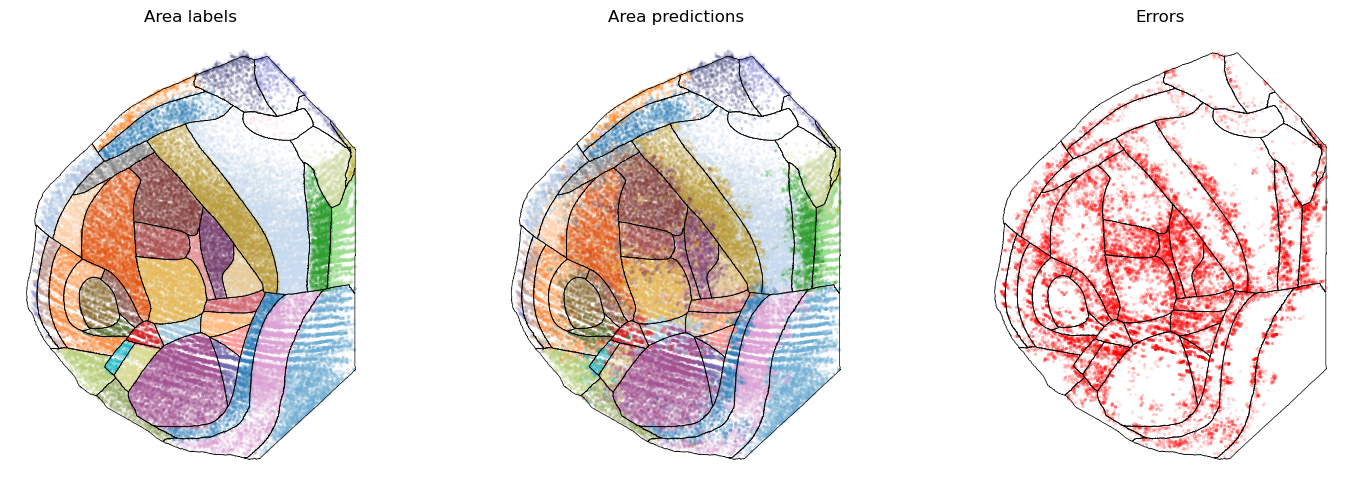

Accuracy 71.7145137924


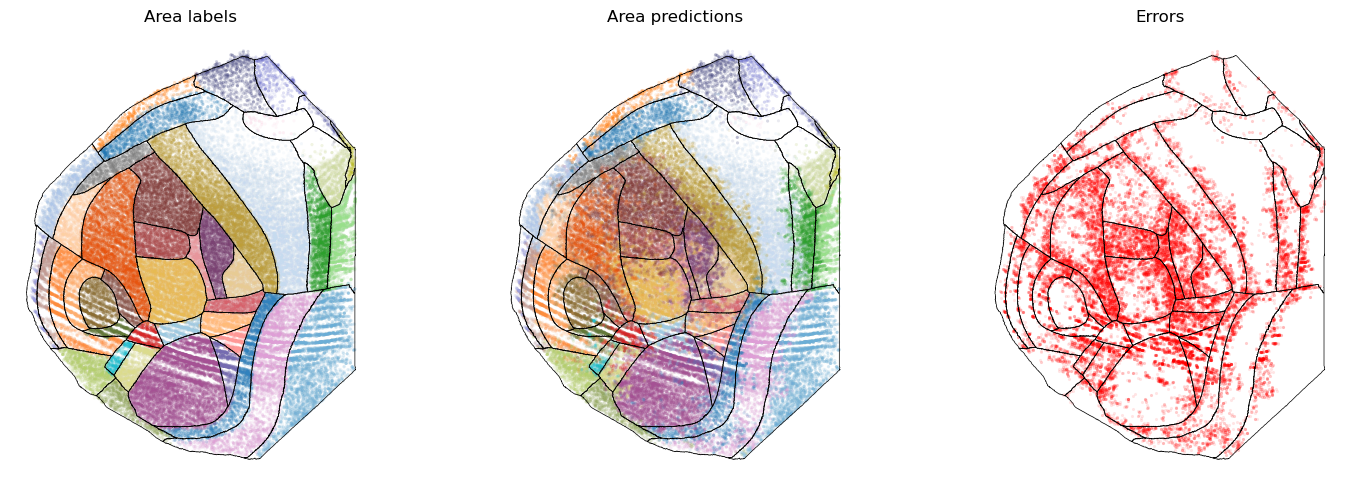

Accuracy 70.3949733506


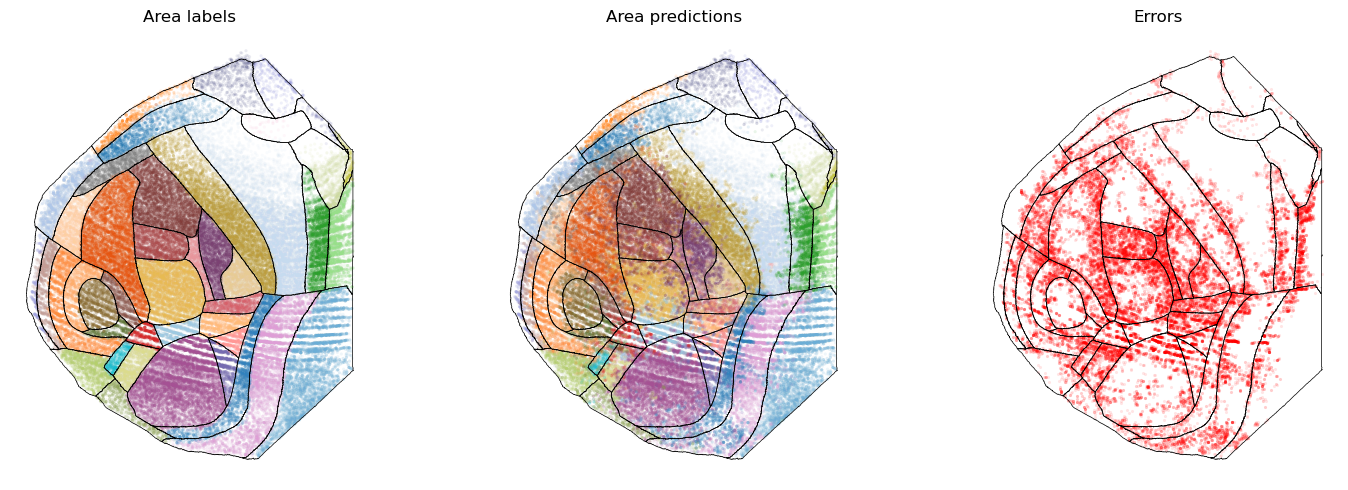

Accuracy 71.3257250983


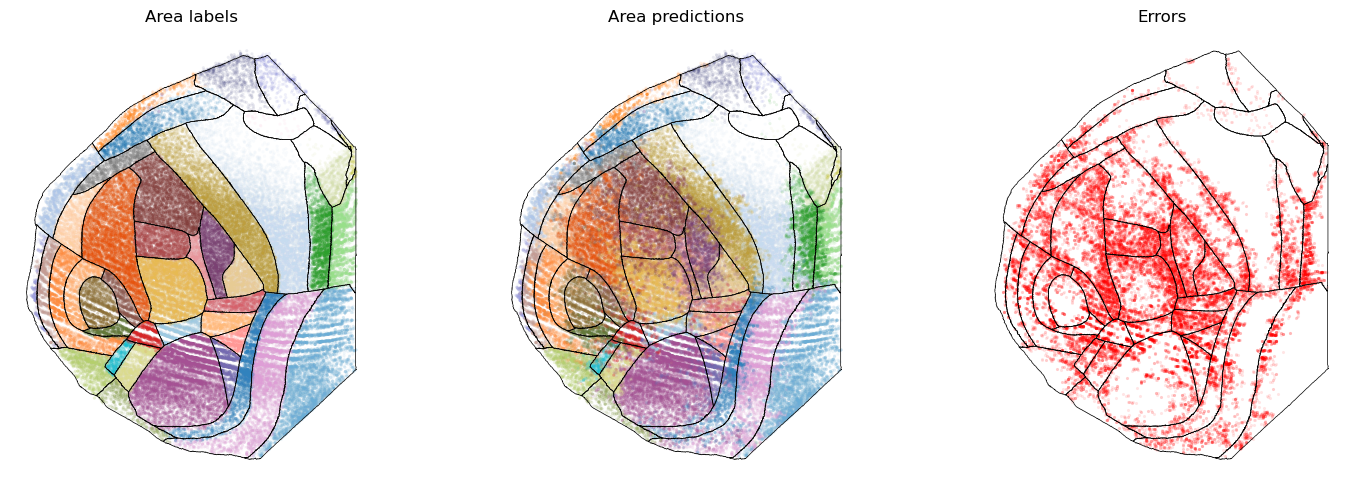

In [39]:
group_size=32
val_or_test = "validation"  

for fold in range(4):
    # Load data
    predictions_path = os.path.join(root_path,f"barseq/annotation/fold{fold}_animal_name_class_weights2_{group_size}/{val_or_test}_brain_predictions_cells.npy")
    pred_dict = np.load(predictions_path, allow_pickle=True).item()
    dataset = load_from_disk(os.path.join(root_path, f"barseq/Chen2023/train_test_barseq_all_exhausted_fold{fold}.dataset"))

    # Prepare data
    labels = np.array(pred_dict['labels']).flatten()
    preds = np.array(pred_dict['predictions']).flatten()
    indices = np.array(pred_dict['indices'])#[:,0].flatten()

    s=1
    xyz = np.array(dataset['train' if val_or_test == "validation" else 'test'][indices]['CCF_streamlines'])
    xyz = reflect_points_to_left(xyz)
    x, y = xyz[::s,0], xyz[::s,1]
    labels, preds = labels[::s], preds[::s]

    # Calculate accuracy
    acc = (preds == labels).sum() / len(labels)
    print("Accuracy", 100*acc)

    # # Plot based on style
    fig, ax = plot_scatter_style(x, y, labels, preds, color_map, bf_left_boundaries_flat,.1)
    plt.savefig(f'fold{fold}_test_enucleated_single-cell-preds-{val_or_test}-{group_size}.png', dpi=300)
    plt.show()
# fig, ax, _ = plot_hexbin_style(x, y, labels, preds, color_map, bf_left_boundaries_flat, label_names)
# # plt.savefig(f'test_enucleated_single-cell-preds-{val_or_test}-{group_size}-hex.png', dpi=300)
# plt.show()


Training SVC with gamma=1.00e-06, C=0.10
Training SVC with gamma=1.00e-06, C=0.46
Training SVC with gamma=1.00e-06, C=2.15
Training SVC with gamma=1.00e-06, C=10.00
Training SVC with gamma=4.64e-06, C=0.10
Training SVC with gamma=4.64e-06, C=0.46
Training SVC with gamma=4.64e-06, C=2.15
Training SVC with gamma=4.64e-06, C=10.00
Training SVC with gamma=2.15e-05, C=0.10
Training SVC with gamma=2.15e-05, C=0.46
Training SVC with gamma=2.15e-05, C=2.15
Training SVC with gamma=2.15e-05, C=10.00
Training SVC with gamma=1.00e-04, C=0.10
Training SVC with gamma=1.00e-04, C=0.46
Training SVC with gamma=1.00e-04, C=2.15
Training SVC with gamma=1.00e-04, C=10.00


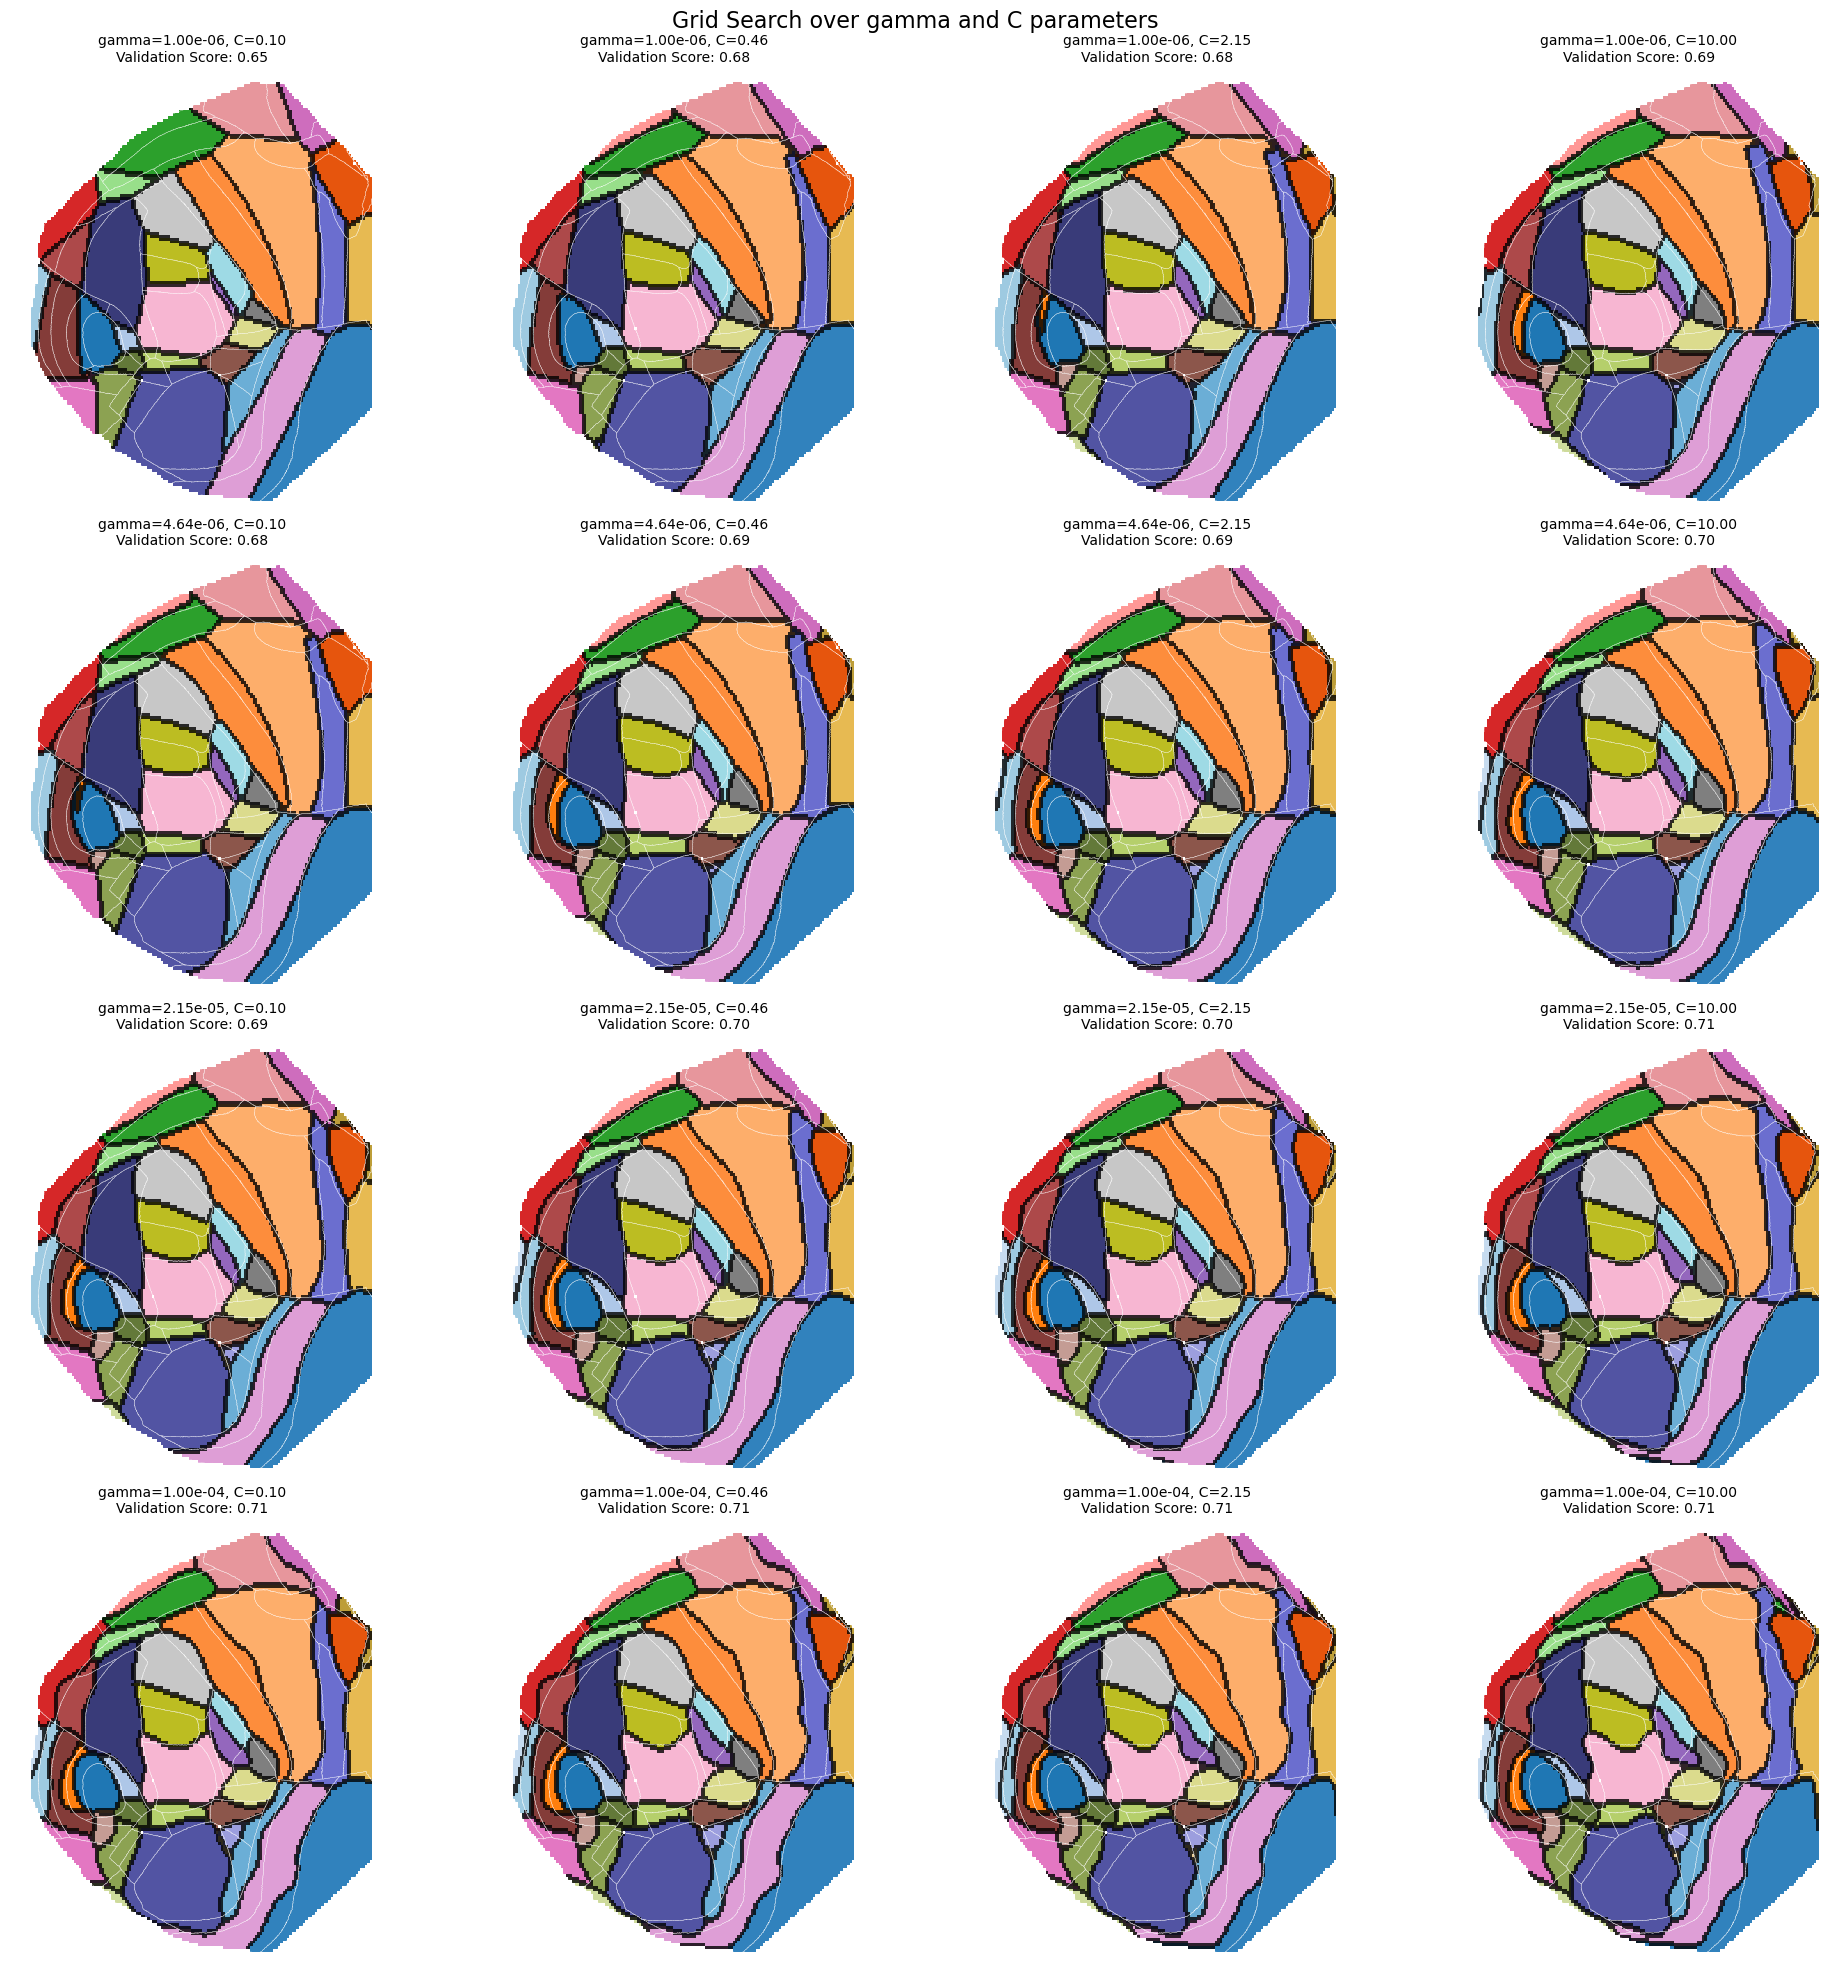

In [20]:
# Define parameter ranges for grid search
gamma_range = np.logspace(-6, -4, 4)  # log range from 1e-6 to 1e-4
c_range = np.logspace(-1, 1, 4)  # log range from 0.1 to 10
s = 2  # Subsampling factor

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
axes = axes.flatten()

# Iterate through parameter combinations
for i, gamma in enumerate(gamma_range):
    for j, C in enumerate(c_range):
        print(f"Training SVC with gamma={gamma:.2e}, C={C:.2f}")

        current_idx = i * 4 + j
        current_ax = axes[current_idx]
        
        # Train model with current parameters
        with SuppressOutput():
            model = SVC(
                kernel='rbf',
                gamma=gamma,
                C=C,
                class_weight=None,
                verbose=False,
            )
            model.fit(xyz[::s, :2], preds[::s])
            
            validation_score = model.score(xyz[1::s, :2], preds[1::s])
        
        # Create decision boundary plot on current subplot
        create_decision_boundary_plot(
            model, 
            xyz[::s, :2], 
            color_map, 
            ax=current_ax,  # Pass the current axis
            grid_resolution=150
        )
        
        del model

        # Add boundary lines
        for k, boundary_coords in bf_left_boundaries_flat.items():
            current_ax.plot(*boundary_coords.T, c="w", lw=0.2)
        
        # Set subplot title
        current_ax.set_title(f"gamma={gamma:.2e}, C={C:.2f}\nValidation Score: {validation_score:.2f}", fontsize=10)
        
        # Remove tick labels for cleaner appearance
        if i < 3:  # Not bottom row
            current_ax.set_xticklabels([])
        if j > 0:  # Not leftmost column
            current_ax.set_yticklabels([])

# Add a common title
plt.suptitle("Grid Search over gamma and C parameters", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Make room for suptitle

# Save the figure
output_path = f"svc_grid_search_gamma_C_subsample_{s}.png"
plt.savefig(output_path)
plt.show()

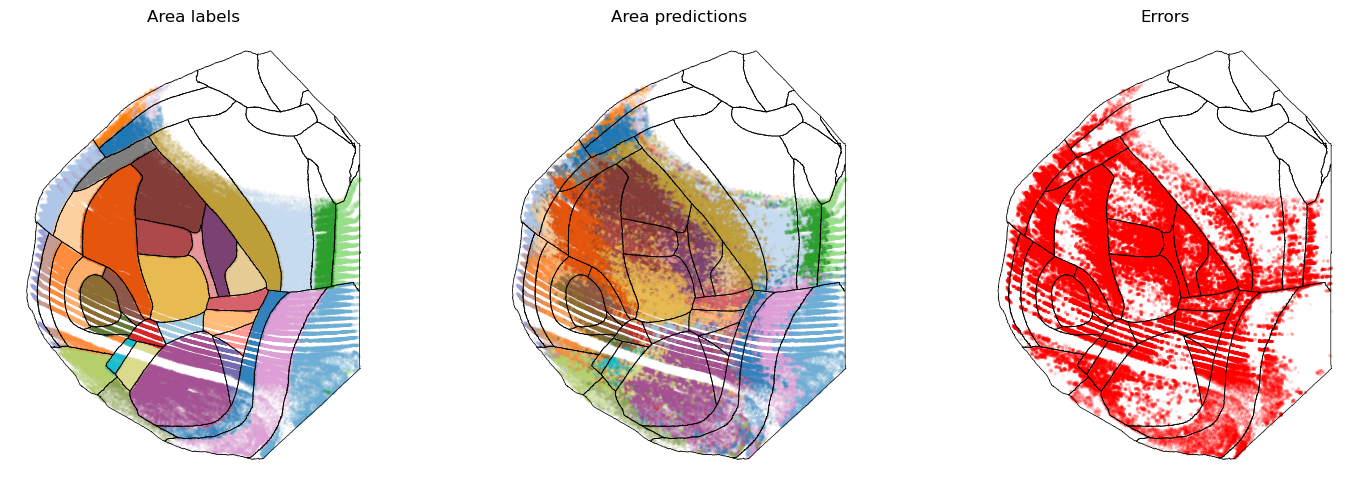

  0%|          | 0/138 [00:00<?, ?it/s]/home/benjami/micromamba/envs/geneformer2/lib/python3.11/site-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 6 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
 99%|█████████▉| 137/138 [01:44<00:00,  1.25it/s]/home/benjami/micromamba/envs/geneformer2/lib/python3.11/site-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 138/138 [01:44<00:00,  1.32it/s]


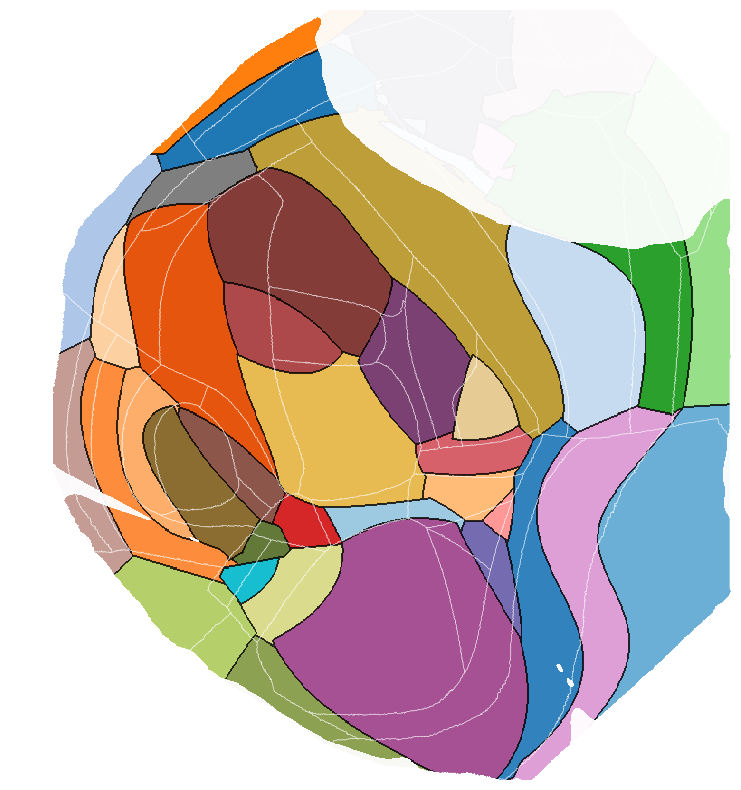

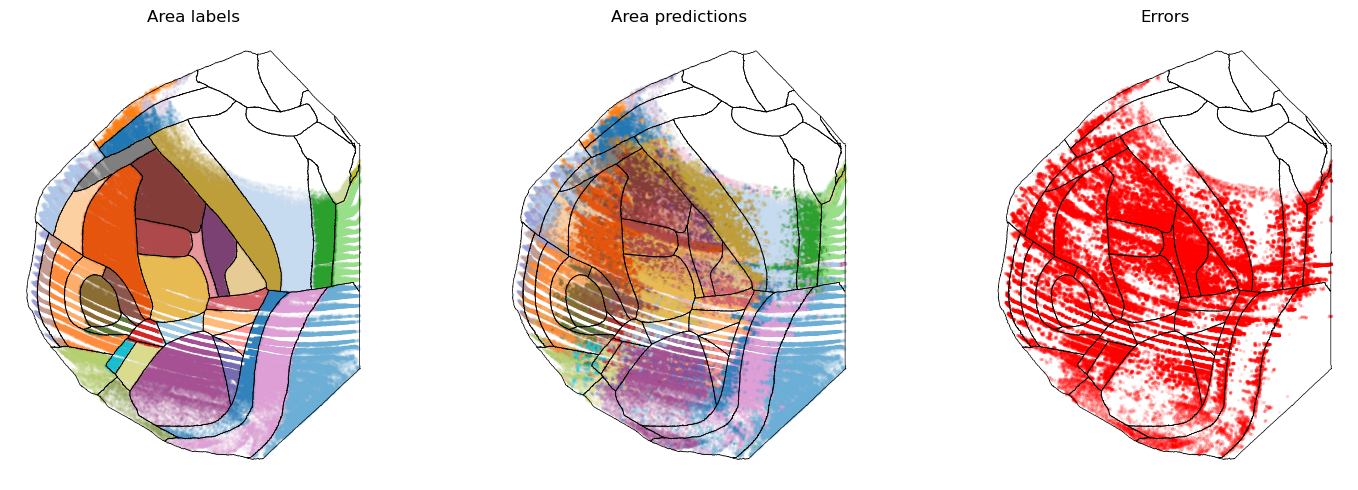

100%|██████████| 138/138 [01:43<00:00,  1.34it/s]


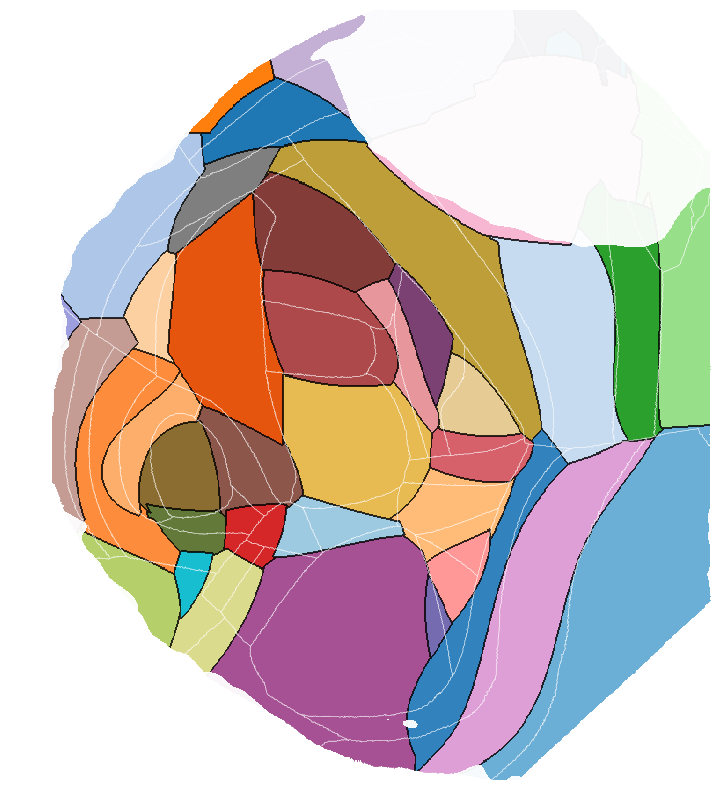

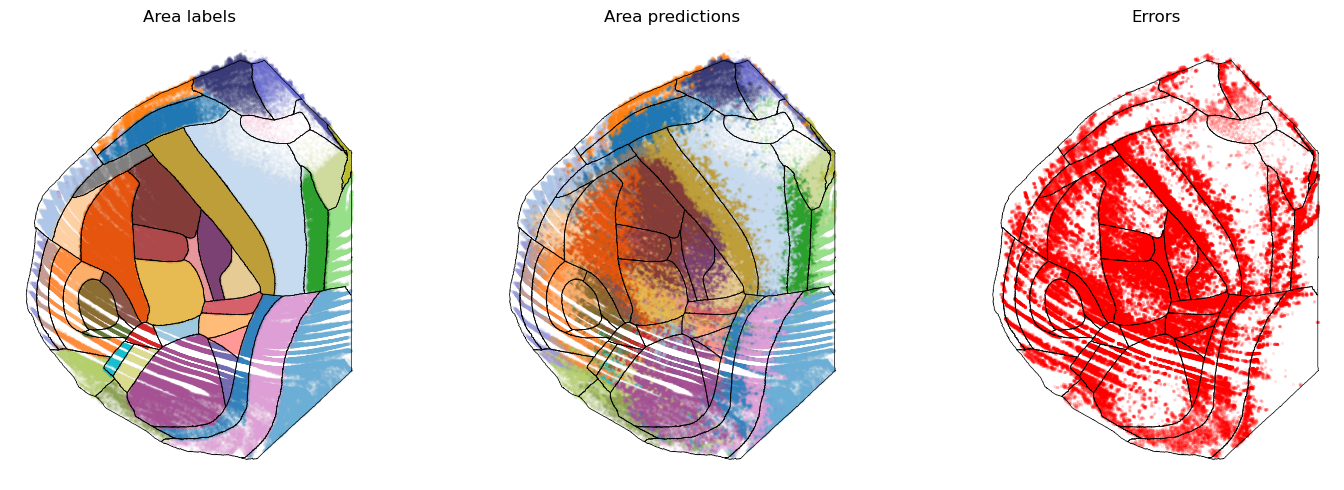

100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


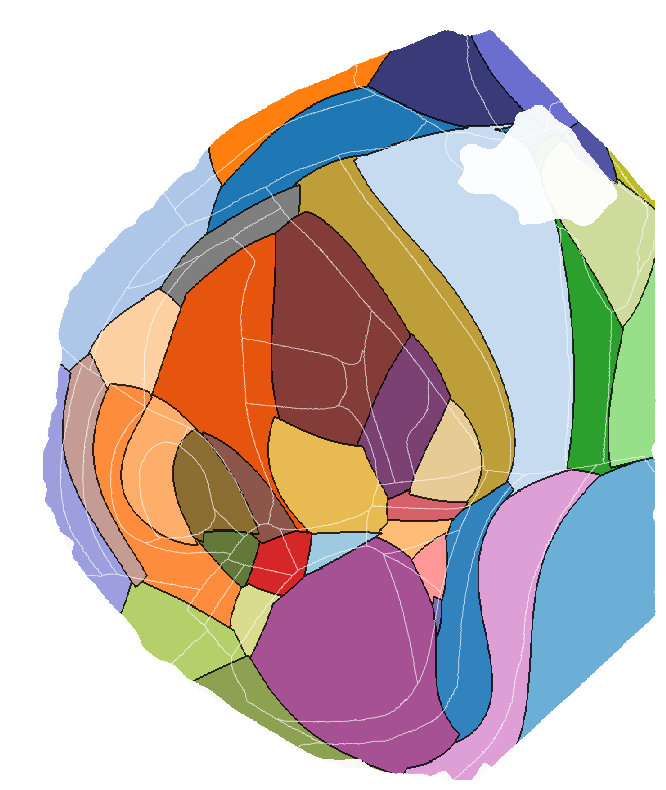

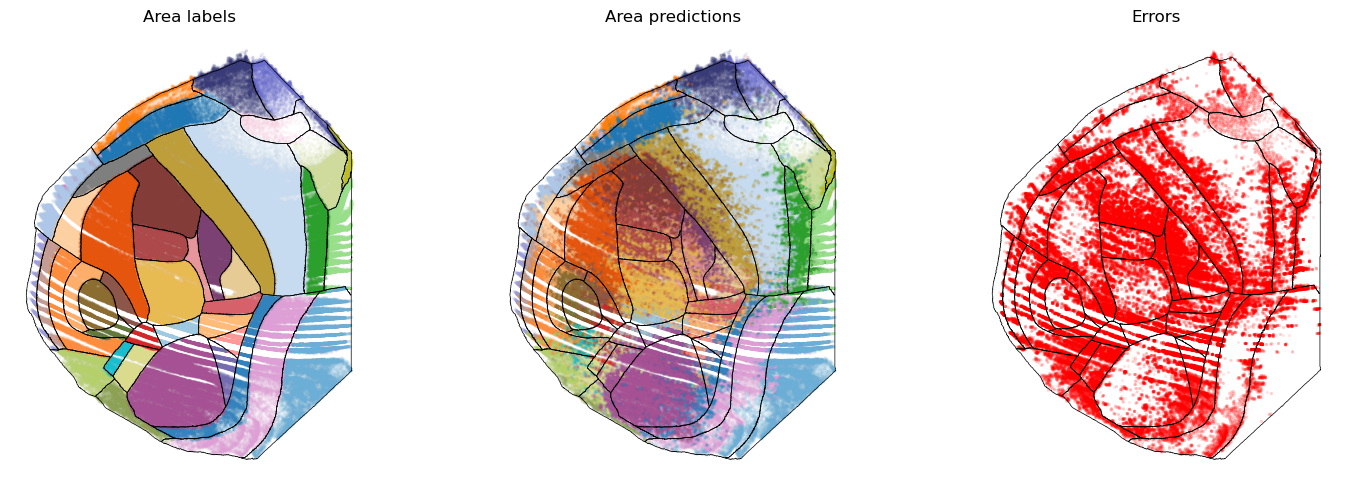

100%|██████████| 138/138 [01:56<00:00,  1.18it/s]


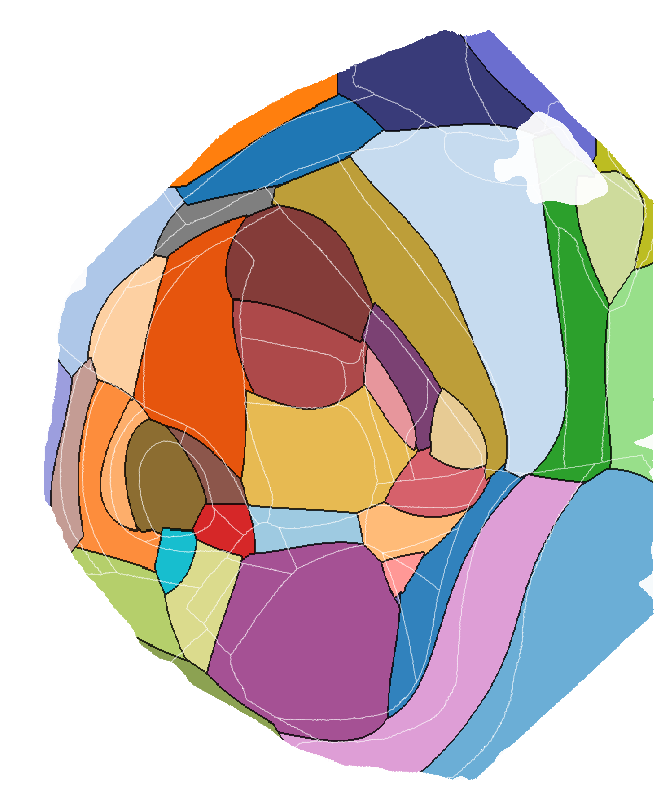

In [9]:
group_size=32
val_or_test = "test"  
 
gamma = 1e-5
C=1

for fold in range(4):

    # Load data
    predictions_path = os.path.join(root_path,f"barseq/annotation/fold{fold}_animal_name_class_weights2_{group_size}/{val_or_test}_brain_predictions_cells.npy")
    pred_dict = np.load(predictions_path, allow_pickle=True).item()
    dataset = load_from_disk(os.path.join(root_path, f"barseq/Chen2023/train_test_barseq_all_exhausted_fold{fold}.dataset"))

    # Prepare data
    labels = np.array(pred_dict['labels']).flatten()
    preds = np.array(pred_dict['predictions']).flatten()
    indices = np.array(pred_dict['indices'])#[:,0].flatten()

    s=1
    xyz = np.array(dataset['train' if val_or_test == "validation" else 'test'][indices]['CCF_streamlines'])
    xyz = reflect_points_to_left(xyz)
    x, y = xyz[::s,0], xyz[::s,1]
    labels, preds = labels[::s], preds[::s]

    # Calculate accuracy
    # acc = (preds == labels).sum() / len(labels)
    # print("Accuracy", 100*acc)

    # # # Plot based on style
    fig, ax = plot_scatter_style(x, y, labels, preds, color_map, bf_left_boundaries_flat,.1)
    plt.savefig(f'fold{fold}_test_enucleated_single-cell-preds-{val_or_test}-{group_size}.png', dpi=300)
    plt.show()
  
    # Train model with current parameters
    with SuppressOutput():
        model = SVC(
            kernel='rbf',
            gamma=gamma,
            C=C,
            class_weight=None,
            verbose=False,
        )
        model.fit(xyz[::s, :2], preds[::s])
        
    
    # Create decision boundary plot on current subplot
    current_ax = create_decision_boundary_plot_with_density_mask(
        model, 
        xyz[::s, :2], 
        color_map, 
        grid_resolution=750,
        density_bandwidth=12,
        batch_size=4096,
        density_mask_alpha=.95,
        density_threshold=.04,
        subsample=2
    )
    
    # Add boundary lines
    for k, boundary_coords in bf_left_boundaries_flat.items():
        current_ax.plot(*boundary_coords.T, c="w", lw=0.25)
        
    # save
    plt.tight_layout()
    plt.savefig(f"fold{fold}_svc_annotation_masked.png")
    plt.show()
